# Regression From Origin

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor as SKEuclideanDecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as SKEuclideanRandomForestRegressor

from src.hyperdt.toy_data import wrapped_normal_mixture
from src.hyperdt.conversions import convert
from src.hyperdt.tree import HyperbolicDecisionTreeRegressor, DecisionTreeRegressor as EuclideanDecisionTreeRegressor
from src.hyperdt.forest import HyperbolicRandomForestRegressor, RandomForestRegressor as EuclideanRandomForestRegressor

INFO: Using numpy backend


### Distance Functions

In [3]:
def euclidean_distance_from_origin(X):
    """Compute the euclidean distance from the origin for each row in X."""
    return np.sqrt(np.sum(X ** 2, axis=1))

def poincare_distance_from_origin(X, eps=1e-5):
    """Compute the hyperbolic distance from the origin for each row in X in the
    Poincare ball model."""
    
    y = np.zeros(X.shape) # origin
    
    x_sqnorm = np.clip(np.sum(X * X, axis=-1), 0, 1 - eps)
    y_sqnorm = np.clip(np.sum(y * y, axis=-1), 0, 1 - eps)
    sqdist = np.sum(np.power(X - y, 2), axis=-1)
    frac = 1 + 2 * sqdist / ((1 - x_sqnorm) * (1 - y_sqnorm))
    poincare_distance = np.arccosh(frac)
    return poincare_distance

def hyperboloid_distance_from_origin(X, curvature=1, timelike_dim=0):
    """Compute the hyperbolic distance from the origin for each row in X in the
    hyperboloid model."""
    
    # Get X space and time components
    space_idxs = np.delete(np.arange(X.shape[1]), timelike_dim)
    X_space, X_time = X[:, space_idxs], X[:, timelike_dim, None]
    
    # Get origin space and time components
    origin_space = np.zeros(X_space.shape)
    origin_time = np.full_like(X_time, np.sqrt(1 / curvature))
    
    assert np.allclose((X_space @ X_space.T - X_time @ X_time.T).diagonal(), -curvature)
    
    # Compute distance
    lorentzian_inner_product = (X_space @ origin_space.T - X_time @ origin_time.T).diagonal()
    hyperboloid_distance = np.sqrt(1 / curvature) * np.arccosh(-curvature * lorentzian_inner_product)
    return hyperboloid_distance

In [4]:
# check that the distance functions are correct

# check #1
root_hyperboloid = [1, 0, 0, 0]
root_poincare = [0, 0, 0]

assert np.all(root_poincare == convert(root_hyperboloid, "hyperboloid", "poincare"))
assert np.all(root_hyperboloid == convert(root_poincare, "poincare", "hyperboloid"))

# check #2
X_hyperboloid, _ = wrapped_normal_mixture(num_points=100, num_classes=4, noise_std=0.5, n_dim=2, seed=42)
X_poincare = convert(X_hyperboloid, "hyperboloid", "poincare")

hyperboloid_distance = hyperboloid_distance_from_origin(X_hyperboloid)
poincare_distance = poincare_distance_from_origin(X_poincare)

assert np.allclose(hyperboloid_distance, poincare_distance)

### Get Distance From Origin

In [5]:
def get_distance_from_origin(n_samples=1000, n_classes=2, noise_std=0.5, n_dim=3, seed=None, return_classes=False):
    """Get data for regression experiments."""
    
    # generate X
    X_hyperboloid, y = wrapped_normal_mixture(
        num_points=n_samples, num_classes=n_classes, noise_std=noise_std, n_dim=n_dim, seed=seed
    )
    X_poincare = convert(X_hyperboloid, "hyperboloid", "poincare")
    
    data = {
        ('poincare', 'euclidean'): (X_hyperboloid, euclidean_distance_from_origin(X_poincare)),
        ('poincare', 'poincare'): (X_hyperboloid, poincare_distance_from_origin(X_poincare)),
        ('hyperboloid', 'euclidean'): (X_hyperboloid, euclidean_distance_from_origin(X_hyperboloid)),
        ('hyperboloid', 'hyperboloid'): (X_hyperboloid, hyperboloid_distance_from_origin(X_hyperboloid, curvature=1)),
    }
        
    if return_classes:
        return data, y
    return data

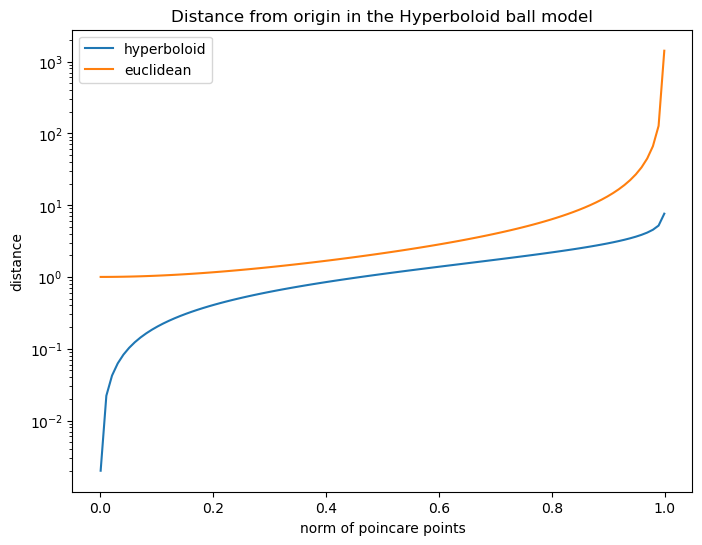

In [6]:
X_poincare = np.concatenate([np.linspace(0.001, 0.999, 100)[:, None], np.zeros((100,1))], axis=1)
X_hyperboloid = convert(X_poincare, "poincare", "hyperboloid")

y_hyperboloid_distance = hyperboloid_distance_from_origin(X_hyperboloid)
y_euclidean_distance = euclidean_distance_from_origin(X_hyperboloid)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(X_poincare[:, 0], y_hyperboloid_distance, label="hyperboloid")
ax.plot(X_poincare[:, 0], y_euclidean_distance, label="euclidean")
ax.set_xlabel("norm of poincare points")
ax.set_ylabel("distance")

# make y axis logarithmic
ax.set_yscale("log")
ax.set_title("Distance from origin in the Hyperboloid ball model")
ax.legend()
plt.show()

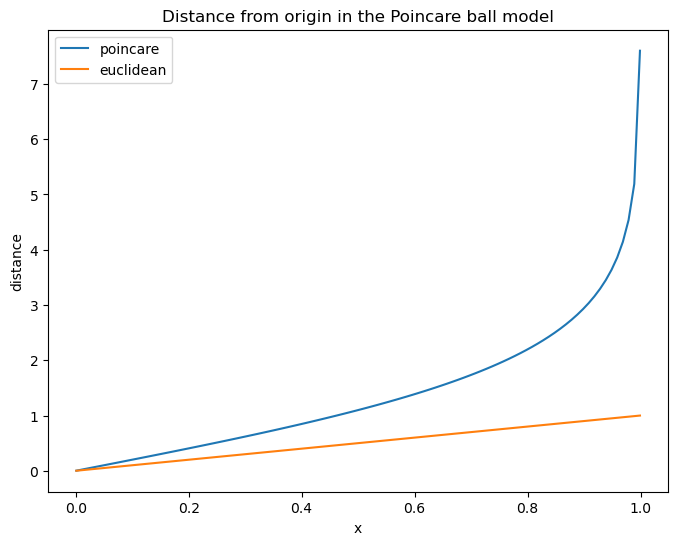

In [7]:
X_poincare = np.concatenate([np.linspace(0.001, 0.999, 100)[:, None], np.zeros((100,1))], axis=1)
# X_hyperboloid = convert(X_poincare, "poincare", "hyperboloid")

y_poincare_distance = poincare_distance_from_origin(X_poincare)
y_euclidean_distance = euclidean_distance_from_origin(X_poincare)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(X_poincare[:, 0], y_poincare_distance, label="poincare")
ax.plot(X_poincare[:, 0], y_euclidean_distance, label="euclidean")
ax.set_xlabel("x")
ax.set_ylabel("distance")

# make y axis logarithmic
ax.set_title("Distance from origin in the Poincare ball model")
ax.legend()
plt.show()

In [8]:
seed = 40
n_dim = 3
noise_std = 0.1
n_samples = 1000
n_classes = 4

data, classes = get_distance_from_origin(
            seed=seed,
            n_dim=n_dim,
            noise_std=noise_std,
            n_samples=n_samples,
            n_classes=n_classes,
            return_classes=True,
            )

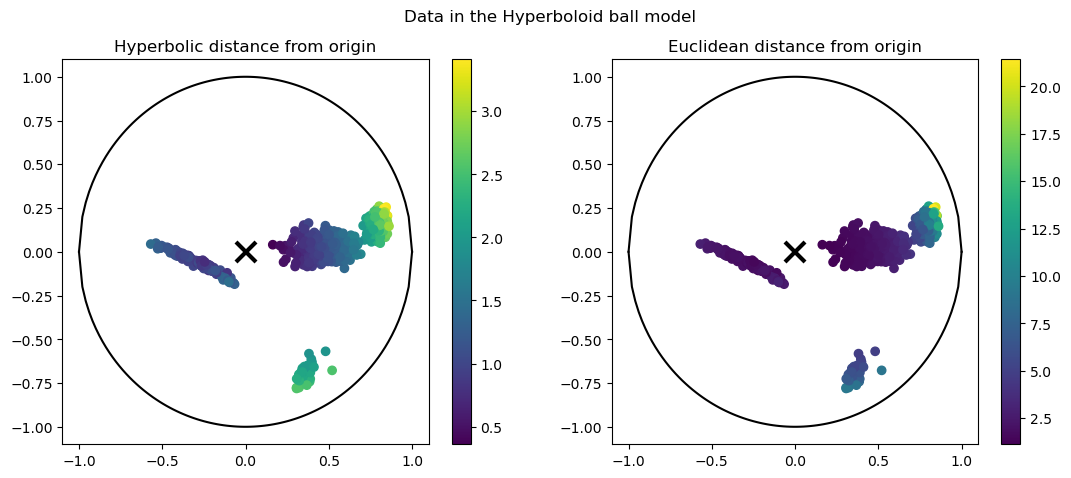

In [9]:
# Plot data in hyperboloid model

_, y_hyp = data[('hyperboloid', 'hyperboloid')]
X, y_ecl = data[('hyperboloid', 'euclidean')]

X_poincare = convert(X, "hyperboloid", "poincare")

fig, axs = plt.subplots(figsize=(13, 5), ncols=2)

mappable = axs[0].scatter(X_poincare[:, 0], X_poincare[:, 1], c=y_hyp, cmap='viridis')
plt.colorbar(mappable)
mappable = axs[1].scatter(X_poincare[:, 0], X_poincare[:, 1], c=y_ecl, cmap='viridis')
plt.colorbar(mappable)

for ax in axs:
    _x = np.linspace(-1, 1, 100)
    _y = np.sqrt(1 - _x ** 2)
    ax.plot(_x, _y, c="black")
    ax.plot(_x, -_y, c="black")
    ax.plot([0], [0], marker="x", c="black", markersize=15, markeredgewidth=3)

axs[0].set_title("Hyperbolic distance from origin")
axs[1].set_title("Euclidean distance from origin")

fig.suptitle("Data in the Hyperboloid ball model")
fig.show()

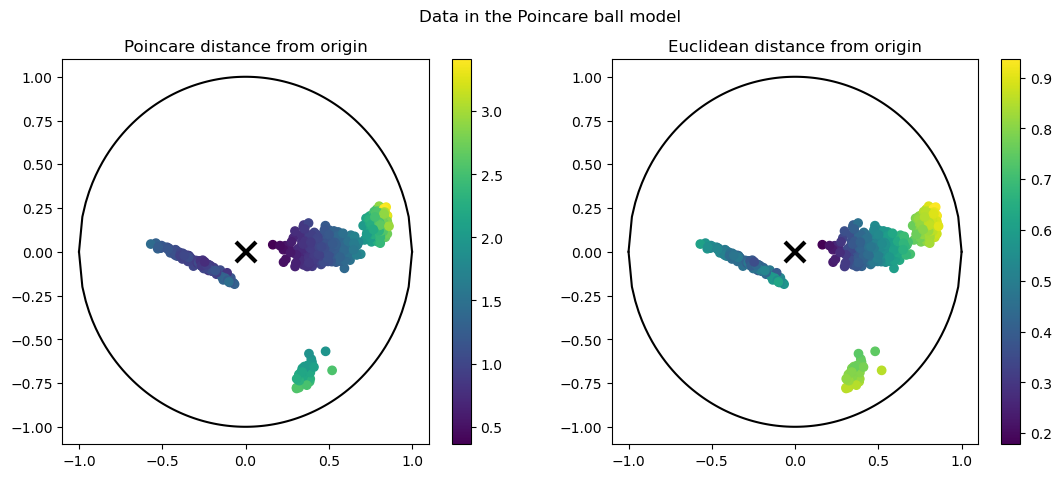

In [10]:
# Plot data in poincare model

_, y_hyp = data[('poincare', 'poincare')]
X, y_ecl = data[('poincare', 'euclidean')]

X_poincare = convert(X, "hyperboloid", "poincare")

fig, axs = plt.subplots(figsize=(13, 5), ncols=2)
mappable = axs[0].scatter(X_poincare[:, 0], X_poincare[:, 1], c=y_hyp, cmap='viridis')
plt.colorbar(mappable)
mappable = axs[1].scatter(X_poincare[:, 0], X_poincare[:, 1], c=y_ecl, cmap='viridis')
plt.colorbar(mappable)

for ax in axs:
    _x = np.linspace(-1, 1, 100)
    _y = np.sqrt(1 - _x ** 2)
    ax.plot(_x, _y, c="black")
    ax.plot(_x, -_y, c="black")
    ax.plot([0], [0], marker="x", c="black", markersize=15, markeredgewidth=3)

axs[0].set_title("Poincare distance from origin")
axs[1].set_title("Euclidean distance from origin")
fig.suptitle("Data in the Poincare ball model")
fig.show()

### Get Arccosh

In [11]:
def get_arccosh(
    seed=seed,
    n_dim=n_dim,
    noise_std=noise_std,
    n_samples=n_samples,
    n_classes=n_classes,
    return_classes=False
    ):

    # generate X
    X_hyperboloid, classes = wrapped_normal_mixture(
        num_points=n_samples, num_classes=n_classes, noise_std=noise_std, n_dim=n_dim, seed=seed
    )

    # filter X b/c arccosh is only defined for values > 1
    mask = X_hyperboloid > 1.1
    X_hyperboloid = X_hyperboloid[mask.all(axis=1)]

    # compute arccosh
    y = np.arccosh(X_hyperboloid).sum(axis=1)
    data = {('hyperboloid', 'hyperboloid'): (X_hyperboloid, y)}
    
    if return_classes:
        return data, classes
    return data

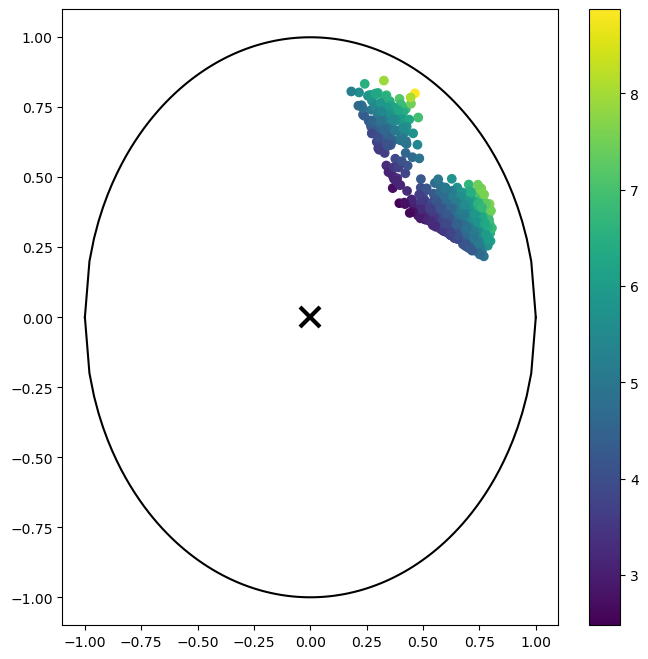

In [12]:
data = get_arccosh(seed=42, n_dim=2, n_samples=10000)
X, y = data[('hyperboloid', 'hyperboloid')]
X_poincare = convert(X, "hyperboloid", "poincare")

fig, ax = plt.subplots(figsize=(8, 8))
mappable = ax.scatter(X_poincare[:, 0], X_poincare[:, 1], c=y, cmap='viridis')
plt.colorbar(mappable)

_x = np.linspace(-1, 1, 100)
_y = np.sqrt(1 - _x ** 2)
ax.plot(_x, _y, c="black")
ax.plot(_x, -_y, c="black")
ax.plot([0], [0], marker="x", c="black", markersize=15, markeredgewidth=3)

fig.show()

### Get Distance From Centroids

### Get Data

In [13]:
def get_data(data_type='origin_distance', seed=None, n_dim=3, noise_std=0.1, n_samples=1000, n_classes=4, return_classes=False):
    
    if data_type == 'origin_distance':
        return get_distance_from_origin(
            seed=seed,
            n_dim=n_dim,
            noise_std=noise_std,
            n_samples=n_samples,
            n_classes=n_classes,
            return_classes=return_classes,
    )
        
    if data_type == 'arcosh_distance':
        return get_arccosh(
            seed=seed,
            n_dim=n_dim,
            noise_std=noise_std,
            n_samples=n_samples,
            n_classes=n_classes,
            return_classes=return_classes
        )

### Train

In [14]:
small = True

data_params = {
    'n_dim': [2],
    'seed': [42, 43, 44],
    'noise_std': [0.1],
    'n_samples': [1000],
    'n_classes': [2, 4],
    }

model_params = {
    'max_depth': [3],
    'n_estimators': [64],
    'min_samples_split': [2],
}

if small:
    data_params['n_dim'] = [n_dim]
    data_params['seed'] = [seed]
    data_params['noise_std'] = [noise_std]
    data_params['n_samples'] = [n_samples]
    data_params['n_classes'] = [n_classes]

In [15]:
from icecream import ic

In [16]:
def percent_rmse(y_true, y_pred, epsilon=1e-5):
    return np.mean(np.abs(y_true - y_pred) / (y_true + epsilon))

In [17]:
models = {
    'hdt': (
        {
            'max_depth': None,
            'min_samples_split': None
            },
        HyperbolicDecisionTreeRegressor
        ),
    'edt': (
        {
            'max_depth': None,
            'min_samples_split': None
            },
        EuclideanDecisionTreeRegressor
        ),
    'sk-edt': (
        {
            'max_depth': None,
            'min_samples_split': None
            },
        SKEuclideanDecisionTreeRegressor
        ),
    'hrf': (
        {
            'max_depth': None,
            'min_samples_split': None,
            'n_estimators': None,
            'n_jobs': -1
            },
        HyperbolicRandomForestRegressor
        ),
    'erf': (
        {
            'max_depth': None,
            'min_samples_split': None,
            'n_estimators': None,
            'n_jobs': -1
            },
        EuclideanRandomForestRegressor
        ),
    'sk-erf': (
        {
            'max_depth': None,
            'min_samples_split': None,
            'n_estimators': None,
            'n_jobs': -1
            },
        SKEuclideanRandomForestRegressor
        ),
    }

In [18]:
params_dict = model_params | data_params
param_values_list = list(product(*params_dict.values()))
param_keys = list(params_dict.keys())
params_prod = [{key: val for key, val in zip(param_keys, param_values)} for param_values in param_values_list]

result_list = []
data_list = []

with tqdm(params_prod) as pbar:
    for params in pbar:
        data = get_data(
            data_type='arcosh_distance',
            seed=params['seed'],
            n_dim=params['n_dim'],
            noise_std=params['noise_std'],
            n_samples=params['n_samples'],
            n_classes=params['n_classes'],
            )
        for (X_geometry, dist_func_name), (X, y) in data.items():
            pbar.set_description('Dim={}, Seed={}, max_depth={}'.format(
                params['n_dim'], params['seed'], params['max_depth']))
            
            # Split data
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=params['seed']
            )
            
            for model_name, (model_params, model) in models.items():
                try:
                    model_params = {k: params[k] if v is None else v for k, v in model_params.items()}
                    model = model(**model_params)
                    model.fit(X_train, y_train)
                    mse_train = percent_rmse(y_train, model.predict(X_train))
                    mse_test = percent_rmse(y_test, model.predict(X_test))
                except ValueError as e:
                    error_msg = str(e)
                    if 'Points must lie on a hyperboloid:' in error_msg: # error due to data not being on hyperboloid
                        mse = np.nan
                    else:
                        raise e

                # save results and data
                result = {
                    'model': model_name,
                    "X geometry": X_geometry,
                    "distance function": dist_func_name,
                } | params | {'mse train': mse_train, 'mse test': mse_test}
                result_list.append(result)
                data_list.append(data)

results = pd.DataFrame(result_list)

Dim=3, Seed=40, max_depth=3: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


In [19]:
results[results['X geometry'] == 'hyperboloid']

,model,X geometry,distance function,max_depth,n_estimators,min_samples_split,n_dim,seed,noise_std,n_samples,n_classes,mse train,mse test
0,hdt,hyperboloid,hyperboloid,3,64,2,3,40,0.1,1000,4,0.065710,0.092786
1,edt,hyperboloid,hyperboloid,3,64,2,3,40,0.1,1000,4,15.736408,18.041501
2,sk-edt,hyperboloid,hyperboloid,3,64,2,3,40,0.1,1000,4,0.022758,0.034029
3,hrf,hyperboloid,hyperboloid,3,64,2,3,40,0.1,1000,4,0.095029,0.141956
4,erf,hyperboloid,hyperboloid,3,64,2,3,40,0.1,1000,4,7.486498,8.559945
5,sk-erf,hyperboloid,hyperboloid,3,64,2,3,40,0.1,1000,4,0.016361,0.021345


In [20]:
results[results['X geometry'] == 'poincare']

,model,X geometry,distance function,max_depth,n_estimators,min_samples_split,n_dim,seed,noise_std,n_samples,n_classes,mse train,mse test


### Save Results

In [21]:
save_results = False

In [22]:
from pathlib import Path 
import pickle

if save_results:

    results_path = Path('results/origin_distance_mse.tsv')
    data_path = Path('results/origin_distance_data.pkl')
    if not results_path.parent.exists():
        results_path.parent.mkdir(parents=True)
        
    results.to_csv(sep='\t', path_or_buf=results_path, index=False)
    with open(data_path, 'wb') as f:
        pickle.dump(data_list, f)

In [23]:
# read results back in for sanity check

if save_results:
    results = pd.read_csv(results_path, sep='\t')
    results